In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 30)

df = pd.read_csv('dataset2.csv')

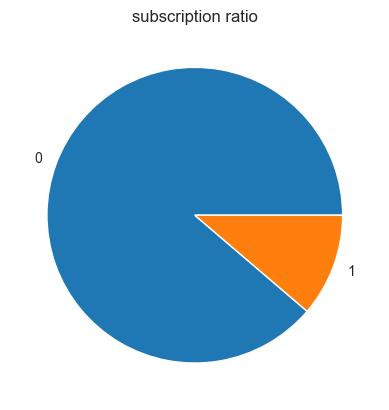

In [3]:
y_counts = df.y.value_counts()
plt.pie(y_counts.values, labels=y_counts.index)
plt.title('subscription ratio');

In [9]:
y_counts

y
0    39487
1     5011
Name: count, dtype: int64

### Using Random Forests without any resampled data (RF Model - 1)

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv('dataset2.csv')
X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=54)
rf_classifier.fit(X_train, y_train)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.9097752808988764
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      7898
           1       0.67      0.39      0.49      1002

    accuracy                           0.91      8900
   macro avg       0.80      0.68      0.72      8900
weighted avg       0.90      0.91      0.90      8900



##### ROC_AUC value

ROC-AUC: 0.68


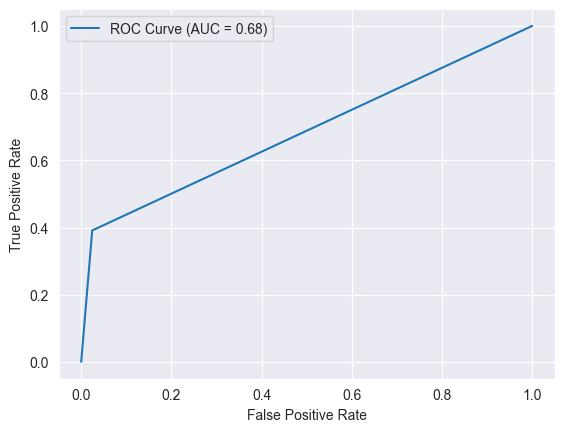

In [17]:
ROC_AUC_plot(y_test, y_pred)

### Using Random Forests with 'SMOTE' (RF Model - 2)

In [18]:
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=175, random_state=54, class_weight='balanced')
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8975280898876404
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      7898
           1       0.54      0.66      0.59      1002

    accuracy                           0.90      8900
   macro avg       0.75      0.79      0.77      8900
weighted avg       0.91      0.90      0.90      8900



##### ROC_AUC values

ROC-AUC: 0.79


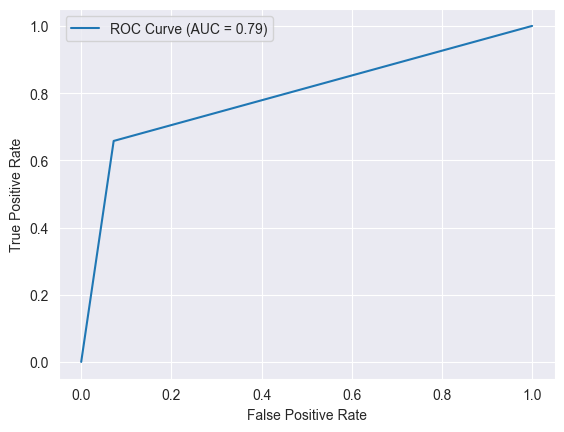

In [19]:
ROC_AUC_plot(y_test, y_pred)

## Requirements of 'optimizing models'

### 1. Model evaluating methods

#### 1) train vs. test accuracy

In [2]:
from sklearn.metrics import accuracy_score

def train_test_accuracy(rf_classifier, X_train_smote, y_train_smote, X_test, y_test):
    # Evaluate performance on the training set
    y_train_pred = rf_classifier.predict(X_train_smote)
    train_accuracy = accuracy_score(y_train_smote, y_train_pred)
    
    # Evaluate performance on the test set
    y_test_pred = rf_classifier.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"Training Accuracy: {train_accuracy:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")


#### 2) cross validation scores

In [3]:
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
import numpy as np

def SKF_CV_accuracy(rf_classifier, X, y):
    smote = SMOTE(random_state=54)
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)
    
    cv_scores = []

    # Perform cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        rf_classifier.fit(X_train_smote, y_train_smote)
        
        accuracy = rf_classifier.score(X_test, y_test)
        cv_scores.append(accuracy)
    
    overall_accuracy = np.mean(cv_scores)
    
    print("Stratified CV Accuracy for each fold:", cv_scores)
    print("Mean Stratified CV Overall Accuracy:", overall_accuracy)
    return overall_accuracy


In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
import numpy as np

def CV_positive_F1(rf_model, X, y):
    rf_classifier = rf_model
    smote = SMOTE(random_state=54)
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)
    
    f1_scores = []
    
    # Perform cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        rf_classifier.fit(X_train_smote, y_train_smote)
        
        y_pred = rf_classifier.predict(X_test)
        
        f1 = f1_score(y_test, y_pred, pos_label=1) 
        f1_scores.append(f1)
    
    # Convert to numpy array for easier calculation
    f1_scores = np.array(f1_scores)
    
    # Output results
    print("Stratified CV F1 Scores for '1' class (positive class):", f1_scores)
    print("Mean Stratified CV F1 Score for '1' class (positive class):", f1_scores.mean())


In [5]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
import numpy as np

def CV_negative_F1(rf_model, X, y):
    rf_classifier = rf_model
    smote = SMOTE(random_state=54)
    
    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=54)
    
    f1_scores = []
    
    # Perform cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        
        rf_classifier.fit(X_train_smote, y_train_smote)
        
        y_pred = rf_classifier.predict(X_test)
        
        f1 = f1_score(y_test, y_pred, pos_label=0)  # Use class '1' for the positive class
        f1_scores.append(f1)
    
    f1_scores = np.array(f1_scores)
    
    print("Stratified CV F1 Scores for '' class (negative class):", f1_scores)
    print("Mean Stratified CV F1 Score for '0' class (negative class):", f1_scores.mean())


#### 3) Confusion matrix


In [35]:
from sklearn.metrics import confusion_matrix 
def plot_confusion_matrix(y_test, y_pred, labels=[0, 1]):
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    print(cm)
    
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

#### 4) ROC_AUC value

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve

def ROC_AUC_plot(y_test, y_pred):
    # Calculating ROC_AUC
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f"ROC-AUC: {roc_auc:.2f}")
    
    import matplotlib.pyplot as plt
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="best")
    plt.show()

### 2) Feature importance

In [9]:
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=175, random_state=54, class_weight='balanced')
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8975280898876404
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      7898
           1       0.54      0.66      0.59      1002

    accuracy                           0.90      8900
   macro avg       0.75      0.79      0.77      8900
weighted avg       0.91      0.90      0.90      8900



In [10]:
import pandas as pd
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
print(importance_df)


      Feature  Importance
9    duration    0.360170
14     lcdays    0.119922
10   campaign    0.102601
5     balance    0.077701
0         age    0.067984
8     contact    0.043324
1         job    0.041584
12   previous    0.038008
13   poutcome    0.033890
6     housing    0.032015
11      pdays    0.031561
3   education    0.025519
2     marital    0.015530
7        loan    0.008995
4     default    0.001196


### 3) Hyper parameter tuning

#### 1) Label Encoded dataset

##### Before hyperparameter tunning

In [5]:
df = pd.read_csv("dataset2.csv")
df['y'] = df['y'].replace({'yes':1, 'no':0})
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=175, random_state=54)
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8975280898876404
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      7898
           1       0.54      0.66      0.59      1002

    accuracy                           0.90      8900
   macro avg       0.75      0.79      0.77      8900
weighted avg       0.91      0.90      0.90      8900



##### Applying Random Search for best parameters

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import classification_report, accuracy_score

# Defining the hyperparameter grid
param_dist = {
    'max_depth': randint(10,20),  # Max depth of the tree
    'min_samples_split': randint(2, 10),  # Minimum samples to split an internal node
    'min_samples_leaf': randint(1, 10),  # Minimum samples at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider at each split
    'bootstrap': [True]  # Whether to bootstrap samples or not
}

rf_classifier = RandomForestClassifier(random_state=54)

# Set up RandomizedSearchCV with recall as the scoring metric
random_search = RandomizedSearchCV(
    rf_classifier,
    param_distributions=param_dist, 
    n_iter=40, 
    cv=3, 
    verbose=1, 
    random_state=54, 
    scoring='recall',  
    n_jobs=-1
)

random_search.fit(X_train_smote, y_train_smote)

best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Use the best model to predict on the test set
y_pred = random_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits


KeyboardInterrupt: 

##### After hyperparameter tunning (RF Model - 3)

In [11]:
df = pd.read_csv("dataset2.csv")
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=156, random_state=54, bootstrap=True, 
                                       max_features='sqrt', min_samples_leaf=3, min_samples_split=3, max_depth=18)
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8928089887640449
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      7898
           1       0.52      0.74      0.61      1002

    accuracy                           0.89      8900
   macro avg       0.74      0.83      0.77      8900
weighted avg       0.91      0.89      0.90      8900



##### Evaluation of the model after parameter tuning

In [12]:
train_test_accuracy(rf_classifier, X_train_smote, y_train_smote, X_test, y_test)

Training Accuracy: 0.9682
Test Accuracy: 0.8928


In [13]:
SKF_CV_accuracy(rf_classifier, X, y)

Stratified CV Accuracy for each fold: [0.886629213483146, 0.8885393258426967, 0.8859550561797753, 0.8914484773570064, 0.8905494999438139]
Mean Stratified CV Overall Accuracy: 0.8886243145612877


np.float64(0.8886243145612877)

In [14]:
CV_positive_F1(rf_classifier, X, y)

Stratified CV F1 Scores for '1' class (positive class): [0.59656138 0.5954323  0.58247635 0.60890688 0.60244898]
Mean Stratified CV F1 Score for '1' class (positive class): 0.5971651769956223


In [15]:
CV_negative_F1(rf_classifier, X, y)

Stratified CV F1 Scores for '' class (negative class): [0.93404798 0.93536617 0.93395797 0.93697808 0.93653896]
Mean Stratified CV F1 Score for '0' class (negative class): 0.9353778315760382


[[7207  691]
 [ 263  739]]


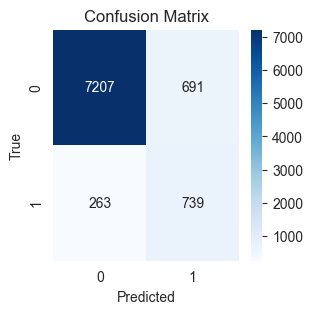

In [36]:
plot_confusion_matrix(y_test, y_pred, labels=[0, 1])

ROC-AUC: 0.83


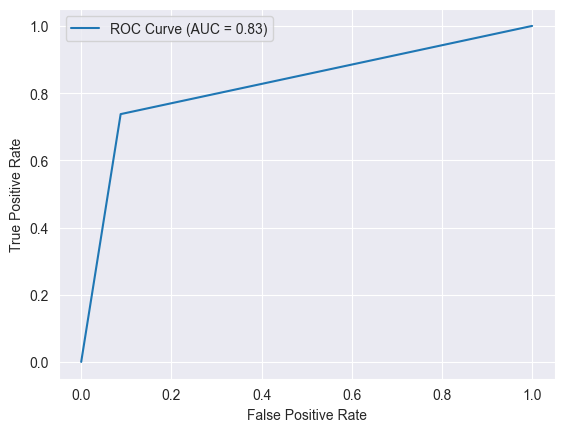

In [18]:
ROC_AUC_plot(y_test, y_pred)

#### 2) Label encoded dataset - irrelavant features removed

##### before hyperparameter tunning

In [52]:
df = pd.read_csv("dataset2.csv")
df = df.drop(columns=['marital', 'loan', 'education', 'default', 'poutcome'])
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=156, random_state=54)
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8956179775280899
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94      7898
         1.0       0.53      0.66      0.59      1002

    accuracy                           0.90      8900
   macro avg       0.74      0.79      0.76      8900
weighted avg       0.91      0.90      0.90      8900



##### Hyper parameter tuning

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import classification_report, accuracy_score

# Defining the hyperparameter grid
param_dist = {
    'max_depth': randint(10,20),  # Max depth of the tree
    'min_samples_split': randint(2, 10),  # Minimum samples to split an internal node
    'min_samples_leaf': randint(1, 10),  # Minimum samples at a leaf node
    'bootstrap': [True]  
}

rf_classifier = RandomForestClassifier(random_state=54)

# Set up RandomizedSearchCV with recall as the scoring metric
random_search = RandomizedSearchCV(
    rf_classifier,
    param_distributions=param_dist, 
    n_iter=40, 
    cv=3, 
    verbose=1, 
    random_state=54, 
    scoring='recall', 
    n_jobs=-1
)

random_search.fit(X_train_smote, y_train_smote)

# Get the best parameters from the random search
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

# Use the best model to predict on the test set
y_pred = random_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best Parameters: {'bootstrap': True, 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 5}
Accuracy: 0.8897752808988764
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94      7898
         1.0       0.51      0.71      0.59      1002

    accuracy                           0.89      8900
   macro avg       0.73      0.81      0.76      8900
weighted avg       0.91      0.89      0.90      8900



##### After hyper parameter tunning (RF Model - 4)

In [37]:
df = pd.read_csv("dataset2.csv")
df = df.drop(columns=['marital', 'loan', 'education', 'default', 'poutcome'])
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=156, random_state=54, bootstrap=True, max_depth=18,
                                        min_samples_leaf=2, min_samples_split=5, max_features='sqrt')
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8895505617977528
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      7898
           1       0.51      0.71      0.59      1002

    accuracy                           0.89      8900
   macro avg       0.73      0.81      0.76      8900
weighted avg       0.91      0.89      0.90      8900



##### Evaluation of the model after parameter tuning

ROC-AUC: 0.81


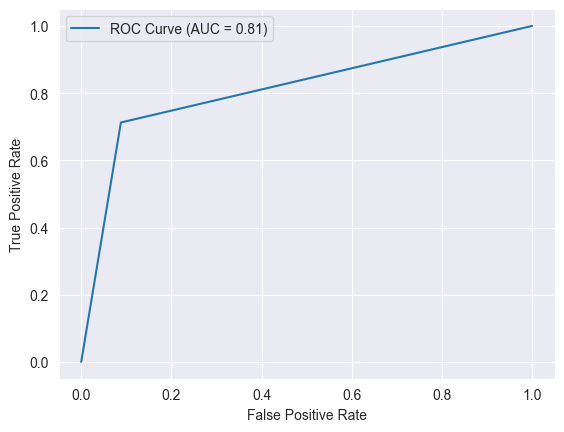

In [28]:
ROC_AUC_plot(y_test, y_pred)

In [38]:
train_test_accuracy(rf_classifier, X_train_smote, y_train_smote, X_test, y_test)

Training Accuracy: 0.9783
Test Accuracy: 0.8896


In [39]:
SKF_CV_accuracy(rf_classifier, X, y)

Stratified CV Accuracy for each fold: [0.8934831460674157, 0.887191011235955, 0.89, 0.8939206652432857, 0.8886391729407799]
Mean Stratified CV Overall Accuracy: 0.8906467990974873


np.float64(0.8906467990974873)

In [41]:
CV_positive_F1(rf_classifier, X, y)

Stratified CV F1 Scores for '1' class (positive class): [0.60761589 0.58717105 0.59259259 0.61120264 0.59764515]
Mean Stratified CV F1 Score for '1' class (positive class): 0.5992454646743


In [44]:
CV_negative_F1(rf_classifier, X, y)

Stratified CV F1 Scores for '' class (negative class): [0.93837754 0.93466944 0.93641618 0.93858165 0.93537659]
Mean Stratified CV F1 Score for '0' class (negative class): 0.9366842810284046


[[7203  695]
 [ 288  714]]


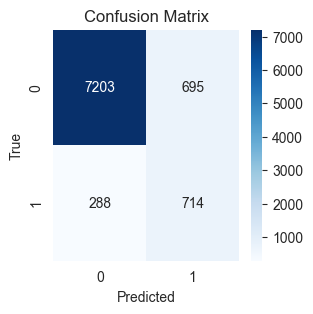

In [43]:
plot_confusion_matrix(y_test, y_pred, labels=[0,1])

#### 3) Label encoded PCA

##### Before hyperparameter tunning

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("dataset2.csv")

X = df.drop(columns=['y'])  
y = df['y']  

# Applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X = pca.fit_transform(X_scaled)

X.shape

(44498, 13)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=200, random_state=54, class_weight='balanced')
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8761797752808989
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      7898
           1       0.46      0.65      0.54      1002

    accuracy                           0.88      8900
   macro avg       0.71      0.78      0.74      8900
weighted avg       0.90      0.88      0.88      8900



##### Randomoized Search

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import classification_report, accuracy_score

# Define the hyperparameter grid
param_dist = {
    'max_depth': randint(10,20),  # Max depth of the tree
    'min_samples_split': randint(2, 10),  # Minimum samples to split an internal node
    'min_samples_leaf': randint(1, 10),  # Minimum samples at a leaf node
    'bootstrap': [True]  # Whether to bootstrap samples or not
}

rf_classifier = RandomForestClassifier(random_state=54)

# Set up RandomizedSearchCV with recall as the scoring metric
random_search = RandomizedSearchCV(
    rf_classifier,
    param_distributions=param_dist, 
    n_iter=40, 
    cv=3, 
    verbose=1, 
    random_state=54, 
    scoring='recall',  # Change scoring metric to 'recall'
    n_jobs=-1
)

random_search.fit(X_train_smote, y_train_smote)

best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

y_pred = random_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best Parameters: {'bootstrap': True, 'max_depth': 17, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy: 0.8629213483146068
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      7898
           1       0.43      0.71      0.54      1002

    accuracy                           0.86      8900
   macro avg       0.70      0.80      0.73      8900
weighted avg       0.90      0.86      0.88      8900



##### After hyper parameter tunning (RF Model - 5)

In [45]:
df = pd.read_csv("dataset2.csv")
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=156, random_state=54, bootstrap=True, max_depth=17,
                                        min_samples_leaf=2, min_samples_split=2, max_features='sqrt')
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8896629213483146
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      7898
           1       0.51      0.72      0.59      1002

    accuracy                           0.89      8900
   macro avg       0.73      0.81      0.77      8900
weighted avg       0.91      0.89      0.90      8900



##### Model evaluation

ROC-AUC: 0.81


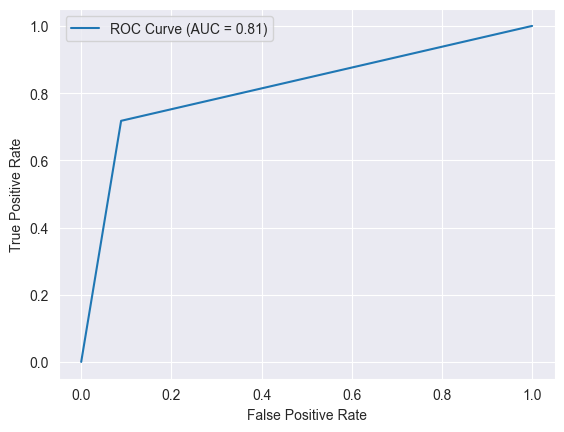

In [32]:
ROC_AUC_plot(y_test, y_pred)

In [46]:
train_test_accuracy(rf_classifier, X_train_smote, y_train_smote, X_test, y_test)

Training Accuracy: 0.9720
Test Accuracy: 0.8897


In [72]:
SKF_CV_accuracy(rf_classifier, X, y)

Stratified CV Accuracy for each fold: [0.8912359550561798, 0.8869662921348315, 0.887191011235955, 0.8941454095965838, 0.8879649398808855]
Mean Stratified CV Overall Accuracy: 0.8895007215808871


np.float64(0.8895007215808871)

In [47]:
CV_positive_F1(rf_classifier, X, y)

Stratified CV F1 Scores for '1' class (positive class): [0.59342422 0.59277304 0.58615004 0.6020284  0.6013986 ]
Mean Stratified CV F1 Score for '1' class (positive class): 0.5951548598630076


In [74]:
CV_negative_F1(rf_classifier, X, y)

Stratified CV F1 Scores for '' class (negative class): [0.93695454 0.93448815 0.93471193 0.93862392 0.93489192]
Mean Stratified CV F1 Score for '0' class (negative class): 0.9359340920909783


[[7199  699]
 [ 283  719]]


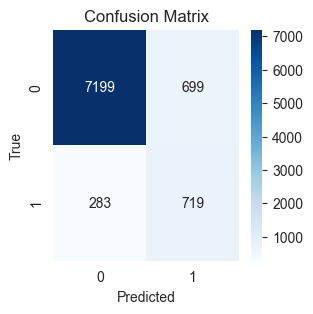

In [48]:
plot_confusion_matrix(y_test, y_pred, labels=[0,1])

#### 4) One hot encoded dataset

##### Before hyperparameter tunning

In [77]:
df = pd.read_csv("dataset1.csv")
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=156, random_state=54)
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8919101123595505
Classification Report:
              precision    recall  f1-score   support

          no       0.95      0.92      0.94      7898
         yes       0.52      0.64      0.57      1002

    accuracy                           0.89      8900
   macro avg       0.73      0.78      0.75      8900
weighted avg       0.90      0.89      0.90      8900



##### RandomizedSearch CV

In [79]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import classification_report, accuracy_score

# Define the hyperparameter grid
param_dist = {
    'max_depth': randint(10,20),  # Max depth of the tree
    'min_samples_split': randint(2, 10),  # Minimum samples to split an internal node
    'min_samples_leaf': randint(1, 10),  # Minimum samples at a leaf node
    'bootstrap': [True]  # Whether to bootstrap samples or not
}

rf_classifier = RandomForestClassifier(random_state=54)

random_search = RandomizedSearchCV(
    rf_classifier,
    param_distributions=param_dist, 
    n_iter=40, 
    cv=3, 
    verbose=1, 
    random_state=54, 
    scoring='recall',  # Change scoring metric to 'recall'
    n_jobs=-1
)

random_search.fit(X_train_smote, y_train_smote)

best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

y_pred = random_search.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")


Fitting 3 folds for each of 40 candidates, totalling 120 fits


C:\Users\sayur\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  warnings.warn(


Best Parameters: {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 3, 'min_samples_split': 9}
Accuracy: 0.878314606741573
Classification Report:
              precision    recall  f1-score   support

          no       0.97      0.89      0.93      7898
         yes       0.47      0.76      0.58      1002

    accuracy                           0.88      8900
   macro avg       0.72      0.83      0.76      8900
weighted avg       0.91      0.88      0.89      8900



##### After hyperparameter tunning (RF Model - 6)

In [49]:
df = pd.read_csv("dataset1.csv")
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

# Smote for training set
smote = SMOTE(random_state=54)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=156, random_state=54, bootstrap=True, max_depth=15,
                                        min_samples_leaf=2, min_samples_split=9, max_features='sqrt')
rf_classifier.fit(X_train_smote, y_train_smote)

y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8779775280898876
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      7898
           1       0.47      0.76      0.58      1002

    accuracy                           0.88      8900
   macro avg       0.72      0.83      0.76      8900
weighted avg       0.91      0.88      0.89      8900



##### Model evaluation

ROC-AUC: 0.83


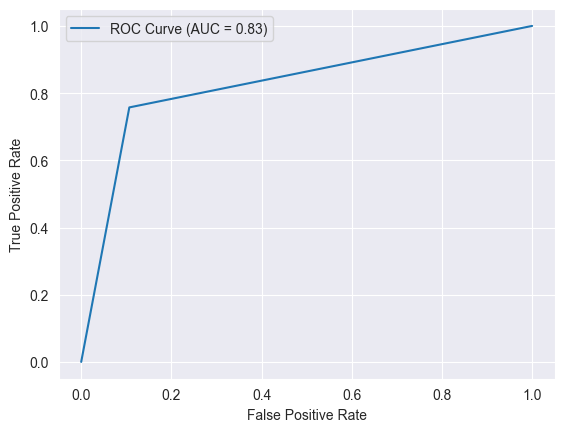

In [34]:
ROC_AUC_plot(y_test, y_pred)

In [50]:
train_test_accuracy(rf_classifier, X_train_smote, y_train_smote, X_test, y_test)

Training Accuracy: 0.9450
Test Accuracy: 0.8780


In [89]:
SKF_CV_accuracy(rf_classifier, X, y)

Stratified CV Accuracy for each fold: [0.8756179775280899, 0.8723595505617977, 0.8769662921348315, 0.8777390718058209, 0.8771772109225756]
Mean Stratified CV Overall Accuracy: 0.8759720205906231


np.float64(0.8759720205906231)

In [51]:
CV_positive_F1(rf_classifier, X, y)

Stratified CV F1 Scores for '1' class (positive class): [0.58430342 0.5748503  0.57475728 0.59097744 0.58519924]
Mean Stratified CV F1 Score for '1' class (positive class): 0.5820175365497967


In [91]:
CV_negative_F1(rf_classifier, X, y)

Stratified CV F1 Scores for '' class (negative class): [0.92686794 0.92490746 0.92807882 0.92812789 0.92791664]
Mean Stratified CV F1 Score for '0' class (negative class): 0.9271797485715506


[[7055  843]
 [ 243  759]]


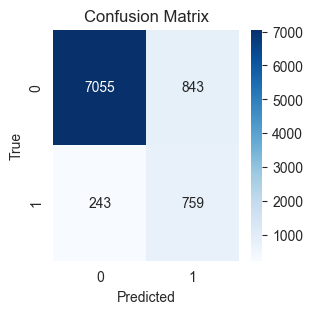

In [52]:
plot_confusion_matrix(y_test, y_pred, labels=[0, 1])

#### 5) SMOTE sampling_strategy tunning

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

df = pd.read_csv('dataset2.csv')

X = df.drop(columns=['y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54, stratify=y)

rf_classifier = RandomForestClassifier(n_estimators=200, random_state=54)

# List of different SMOTE sampling strategies to evaluate
sampling_strategies = [0.3,0.31,0.32,0.325,0.33,0.335]

results = []

# Iterate through each sampling strategy
for strategy in sampling_strategies:
    # Apply SMOTE with the current sampling strategy
    smote = SMOTE(sampling_strategy=strategy, random_state=54)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    
    # Train the RandomForestClassifier on the resampled data
    rf_classifier.fit(X_train_smote, y_train_smote)
    
    y_pred = rf_classifier.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    results.append({
        'sampling_strategy': strategy,
        'accuracy': accuracy,
        'f1_score': report['weighted avg']['f1-score']  
    })

best_result = max(results, key=lambda x: x['f1_score'])

for result in results:
    print(f"Sampling Strategy: {result['sampling_strategy']}, Accuracy: {result['accuracy']:.4f}, F1 Score: {result['f1_score']:.4f}")

print("\nBest SMOTE Sampling Strategy:", best_result['sampling_strategy'])
print("Best F1 Score:", best_result['f1_score'])


Sampling Strategy: 0.3, Accuracy: 0.9076, F1 Score: 0.9050
Sampling Strategy: 0.31, Accuracy: 0.9078, F1 Score: 0.9052
Sampling Strategy: 0.32, Accuracy: 0.9096, F1 Score: 0.9071
Sampling Strategy: 0.325, Accuracy: 0.9066, F1 Score: 0.9044
Sampling Strategy: 0.33, Accuracy: 0.9060, F1 Score: 0.9038
Sampling Strategy: 0.335, Accuracy: 0.9055, F1 Score: 0.9033

Best SMOTE Sampling Strategy: 0.32
Best F1 Score: 0.9070789992169208


##### After sampling_strategy tunning (RF Model - 7)

In [35]:
X = df.drop(columns=['y'])
y = df['y']

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=54, stratify=y)

# # Balanced test set
# df1 = pd.concat([X_test, y_test], axis=1)
# no_df = df1[df1.y == 0].sample(1002)
# yes_df = df1[df1.y == 1]
# df2 = pd.concat([yes_df, no_df], axis=0)
# X_test = df2.drop(columns=['y'])
# y_test = df2['y']

# Smote for training set
smote = SMOTE(random_state=54, sampling_strategy=0.32)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier(n_estimators=156, random_state=54, bootstrap=True, max_depth=15,
                                        min_samples_leaf=3, min_samples_split=3, max_features='sqrt')
rf_classifier.fit(X_train_smote, y_train_smote)


y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.9047191011235955
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      7898
           1       0.58      0.56      0.57      1002

    accuracy                           0.90      8900
   macro avg       0.76      0.75      0.76      8900
weighted avg       0.90      0.90      0.90      8900



ROC-AUC: 0.75


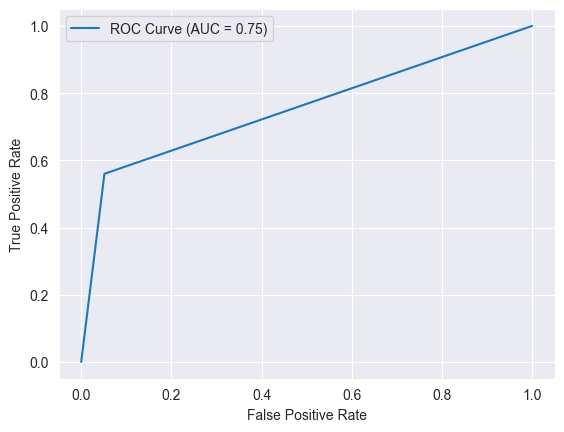

In [36]:
ROC_AUC_plot(y_test, y_pred)